In [173]:
import pandas as pd
import os,sys
import networkx as nx

import pandas as pd
from os.path import join as opj
from tqdm import tqdm

import numpy as np
from itertools import chain
import pickle

import gensim
import random
import multiprocessing
from collections import defaultdict
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
import itertools

In [139]:
rebel_rels = pd.read_pickle('./data/REBEL/arxiv/arxiv_main_graph.pickle')
pfn_rels = pd.read_pickle('./data/PFN/arxiv/extracted_rels_arxiv.pickle')

In [140]:
rebel_rels

,edge,source,target
0,has part,2d field theory,2d one
1,part of,2d one,2d field theory
2,facet of,original model,scale invariant theory
3,subclass of,2d conformal model,conformal model
4,subclass of,noise free KPZ equation,reaction diffusion equation
...,...,...,...
1277531,facet of,shot capability,system
1277532,subclass of,adversarial training problem,meta learning
1277533,use,generator,training
1277534,use,discriminator,training


In [141]:
pfn_rels

,source,target,edge
4,categorical form,structure,Feature-of
6,approach,quantization of causal sites,Used-for
7,projective threespace,smooth quartic surface,Feature-of
10,object detector,bootstrap particle filter PF,Used-for
21,algorithm,alternatives,Compare
...,...,...,...
1098582,throughput,resource bounds,Conjunction
1098592,minimal latency,baselines,Evaluate-for
1098593,minimal latency,resource bounds,Conjunction
1098604,query level accuracy,baselines,Evaluate-for


# Analysis
### a. Most frequent relations 

In [ ]:
pfn_rel

## b. Relations distribution

In [154]:
def get_relation_value_counts(data):
    unique_relation_types_counter = dict(Counter(data))
    unique_relation_types_vc = dict(sorted(unique_relation_types_counter.items(), key=lambda t: t[1], reverse=True))
    return unique_relation_types_vc

In [175]:
def plot_rels_dist(data, method_name):
    plt.figure(figsize=(13, 7))# (16, 12))
    data = dict(itertools.islice(data.items(), 20))
    sns.barplot(x=list(data.keys()), y=list(data.values()))
    plt.xticks(rotation=85, fontsize=14)
    plt.title(f'{method_name}: Realtions distribution')
    plt.xlabel('Relation type')
    plt.ylabel('# of relations')
    plt.show()

### PFN method

In [159]:
pfn_relation_types_vc = get_relation_value_counts(pfn_rels.edge)

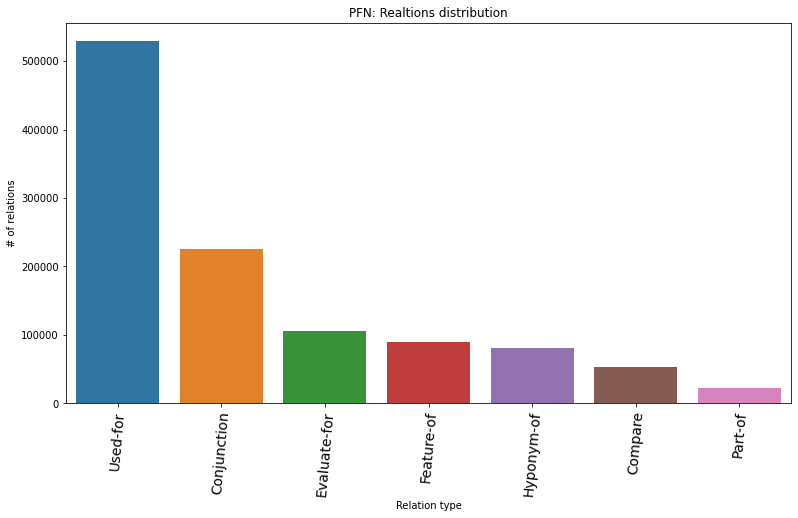

In [176]:
plot_rels_dist(data=pfn_relation_types_vc, method_name='PFN')

### REBEL

In [161]:
rebel_relation_types_vc = get_relation_value_counts(rebel_rels.edge)

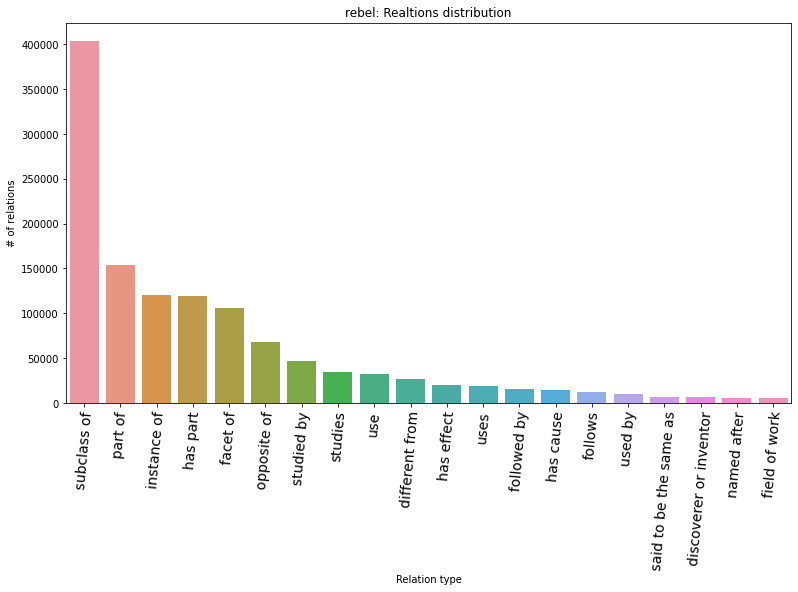

In [177]:
plot_rels_dist(data=rebel_relation_types_vc, method_name='rebel')

In [6]:
def print_top_entities_for_relation(data, relation_type):
    edges = data[data.edge.isin([relation_type])]
    return edges.head(20)

In [7]:
print_top_entities_for_relation(data=pfn_rels, relation_type='Conjunction')

,source,target,edge
104,magnetic monopoles,electromagnetic duality,Conjunction
152,resistance,recommendation effectiveness,Conjunction
154,attribute inference attacks,recommendation effectiveness,Conjunction
176,stretch and bend vibrational spectrum,intensity of infrared transitions,Conjunction
208,spectral slopes,PAH 6 . 2um luminosities,Conjunction
261,IR QSOs,PAH with 60um luminosities,Conjunction
265,IR QSOs,supernovae,Conjunction
267,EW PAH 6,PAH with 60um luminosities,Conjunction
272,AGNs,PAH with 60um luminosities,Conjunction
277,AGNs,supernovae,Conjunction


## Sample corpus of random walks

In [8]:
def init_child(_graph, _pars):
    global G, n_iters, seed, w_length
    G = _graph
    n_iters = _pars["niters"]
    seed = _pars["seed"]
    w_length = _pars['w_length']


def run_walks_g(start_node):
    corpus = []
    random.seed(seed)
    np.random.seed(seed)
    for chosen_node in [start_node]:
        for _ in range(n_iters):
            path = [chosen_node]
            for _ in range(w_length-1):
                neighbors = G.successors(path[-1])
                filtered_neighbors = set(neighbors) - set(path)
                filtered_neighbors = list(set(filtered_neighbors))
                filtered_neighbors.sort()
                if len(filtered_neighbors) == 0:
                        break
                next_node = np.random.choice(filtered_neighbors)
                path.append(next_node)
            
            corpus.append(path)
    return corpus


def sample_heterogeneous_random_walks(graph):

    threads = 12
    chunkdiv = 20
    walks_per_node = 5
    seed = 42
    walk_length = 20

    available_start_nodes = np.array(graph.nodes())
    available_start_nodes.sort()


    chlen = len(available_start_nodes)//(threads*chunkdiv)
    pbar = tqdm(total=len(available_start_nodes))
    res = []
    pars = {}

    pars["seed"] = seed
    pars["niters"] = walks_per_node
    pars["w_length"] = walk_length

    pool = multiprocessing.Pool(processes=threads, initializer=init_child,
                initargs=(graph, pars))

    for walk in pool.imap(run_walks_g, available_start_nodes, chunksize=chlen):
        res += walk #.append("\n".join(walk) )
        pbar.update(1)
    pool.close()
    pool.join()

    return res

In [9]:
def get_unique_entities(walks):
    walks = [walk for walk in walks if len(walk) > 1]
    chain_walks = list(chain(*walks))
    unique_tokens_in_corpus = set(chain_walks)
    print('Number of unique tokens in corpus: ', len(unique_tokens_in_corpus))
    return walks, unique_tokens_in_corpus

def get_embeddings(unique_tokens, model, out_filename):
    dict_of_tokens_df = {}
    for token in unique_tokens:
        try:
            dict_of_tokens_df[token] = model.wv[token]
        except KeyError:
            pass
    entity_embeddings = pd.DataFrame(dict_of_tokens_df).transpose().rename_axis('entity').reset_index()
    entity_embeddings.to_pickle(out_filename)
    return entity_embeddings



## Embeddings for PFN graph

In [10]:
pfn_graph = nx.from_pandas_edgelist(pfn_rels, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

In [11]:
print(nx.info(pfn_graph))

MultiDiGraph with 758783 nodes and 971172 edges


In [12]:
walks_pfn = sample_heterogeneous_random_walks(graph=pfn_graph)

100%|██████████| 758783/758783 [01:48<00:00, 6981.16it/s] 


In [13]:
with open('pfn_graph_rw.pickle', 'wb') as handle:
    pickle.dump(walks_pfn, handle)

In [14]:
corpus_pfn, unique_tokens_in_corpus_pfn = get_unique_entities(walks=walks_pfn)

Number of unique tokens in corpus:  665477


In [15]:
model_pfn = gensim.models.Word2Vec(sentences=corpus_pfn, min_count=1, vector_size=64, seed=42, sg=1, workers=7) # workers=self.workers

In [16]:
pfn_embeddings = get_embeddings(unique_tokens=unique_tokens_in_corpus_pfn, model=model_pfn, out_filename='pfn_embeddings_w2v.pickle')

In [17]:
pfn_embeddings

,entity,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,higher dimensional manifold,0.034547,-0.094241,0.047035,0.009159,0.003111,-0.066225,-0.002496,-0.015083,-0.001848,...,0.013181,0.012880,-0.014165,-0.059290,-0.060364,-0.028410,-0.000160,0.016618,0.123714,0.081467
1,robot architectures,0.030633,-0.062755,0.059944,0.012458,0.045975,-0.052501,0.016918,0.013015,-0.044257,...,0.004330,-0.001469,0.006013,-0.056168,-0.063509,-0.047416,-0.005274,0.040821,0.099596,0.045311
2,three dimensional pipe flow,0.028886,-0.072850,0.042598,-0.001262,0.027652,-0.055588,0.000206,-0.015575,-0.033364,...,-0.015947,-0.002446,0.008044,-0.031799,-0.016319,-0.023055,-0.017007,0.025399,0.083774,0.060422
3,solenoid lens,0.050770,-0.057781,0.061612,0.005901,0.015192,-0.080932,0.009246,-0.029574,-0.021362,...,0.026900,-0.003139,-0.012888,-0.051014,-0.055189,-0.032900,0.011352,0.040711,0.138401,0.087603
4,MiniONN,0.109976,-0.161539,0.086551,-0.011095,0.058066,-0.112867,-0.019754,-0.022982,-0.058417,...,0.022290,-0.036908,-0.053206,-0.066526,-0.148938,-0.088734,-0.001461,0.063101,0.175885,0.082884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665472,orthogonal class,0.062711,-0.122307,0.104362,0.001267,0.050982,-0.112246,0.004408,-0.038099,-0.035520,...,0.037834,0.011703,0.004909,-0.058276,-0.071168,-0.063151,-0.022430,0.059500,0.173696,0.104555
665473,log Sobolev type inequality,0.109666,-0.149745,0.137818,0.030483,0.003911,-0.120372,0.014793,-0.035571,-0.095974,...,0.000479,0.021303,0.000296,-0.075577,-0.043531,-0.110518,0.008867,0.051127,0.147361,0.103354
665474,superplasticity,0.071894,-0.127764,0.062424,0.004395,0.056917,-0.084671,-0.016921,-0.000683,-0.023228,...,0.014003,0.009251,-0.006899,-0.083336,-0.064868,-0.054701,-0.012754,0.066114,0.161611,0.097339
665475,sums of Hilbert space frames,0.095777,-0.145915,0.134581,0.017444,0.044417,-0.154594,0.023935,-0.041457,-0.046342,...,0.039521,0.014362,0.002289,-0.121797,-0.098378,-0.091944,0.004156,0.085312,0.211144,0.137188


## Embeddings for REBEL

In [18]:
rebel_graph = nx.from_pandas_edgelist(rebel_rels, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

In [19]:
print(nx.info(rebel_graph))

MultiDiGraph with 664132 nodes and 1149782 edges


In [20]:
walks_rebel = sample_heterogeneous_random_walks(graph=rebel_graph)

100%|██████████| 664132/664132 [01:17<00:00, 8577.09it/s] 


In [21]:
with open('rebel_graph_rw.pickle', 'wb') as handle:
    pickle.dump(walks_rebel, handle)

In [22]:
corpus_rebel, unique_tokens_in_corpus_rebel = get_unique_entities(walks=walks_rebel)

Number of unique tokens in corpus:  639146


In [23]:
model_rebel = gensim.models.Word2Vec(sentences=corpus_rebel, min_count=1, vector_size=64, seed=42, sg=1, workers=7) # workers=self.workers


In [24]:
rebel_embeddings = get_embeddings(unique_tokens=unique_tokens_in_corpus_rebel, model=model_rebel, out_filename='rebel_embeddings_w2v.pickle')

In [25]:
rebel_embeddings

,entity,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,higher dimensional manifold,-0.040160,-0.977115,0.674561,-0.275147,-0.272521,-0.168228,0.499957,0.515158,0.346035,...,-0.308417,0.255880,0.175917,-0.001147,0.334485,0.332582,-0.181207,0.807521,-0.211791,0.248036
1,globally distinguished representation,-0.119682,-0.097797,0.175936,-0.012959,-0.030870,-0.044621,0.066730,-0.054203,0.020064,...,-0.008359,0.012235,0.075498,-0.085041,0.078165,0.024660,-0.084735,-0.005476,-0.007197,-0.014907
2,A like,-0.374899,-0.051359,0.299906,-0.069462,-0.045523,-0.110750,0.243123,-0.132379,0.069445,...,-0.184413,0.109576,0.183808,-0.288676,0.121918,-0.004692,-0.135005,-0.054465,0.101525,-0.089477
3,type case,-0.078717,-0.004304,0.104942,0.004519,-0.062624,0.008192,0.034231,-0.036199,0.002670,...,-0.009738,0.034109,0.032710,-0.014242,0.081406,0.009557,-0.031643,-0.033400,0.017481,0.024278
4,UJT RO,-0.229235,-0.060061,0.360562,-0.043691,-0.026552,0.075704,0.215773,-0.126771,0.088855,...,-0.044169,0.008843,0.134973,-0.129087,0.117914,0.151015,0.003629,-0.033489,0.106454,-0.020332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639141,compute oracle,-0.091289,-0.257443,0.295029,0.029902,-0.132066,-0.282375,0.179305,-0.189810,-0.019033,...,-0.088510,0.202646,0.369558,0.097367,0.096957,-0.071945,-0.301740,-0.019195,-0.208439,0.179664
639142,empty site,-0.121642,-0.195255,0.439108,0.056549,0.163553,-0.049834,0.239073,-0.049745,-0.038428,...,0.161165,0.190312,0.296220,-0.032711,0.143677,0.045085,-0.163888,-0.025018,-0.030917,0.068896
639143,NP equation,-0.129936,-0.024946,0.159205,-0.040806,-0.045693,-0.044762,0.109142,-0.053680,0.043835,...,-0.008899,0.034635,0.045272,-0.079999,0.067197,0.020936,-0.077952,-0.003430,0.024837,0.026088
639144,smooth solid,-0.174145,-0.057076,0.236102,-0.035570,-0.018229,-0.043491,0.133631,-0.133570,0.044193,...,-0.051067,0.077367,0.070251,-0.104165,0.133944,0.035512,-0.139964,0.052482,0.029281,0.000241


# Get classes of entities by relation types

In [32]:
def print_top_entities_for_relation(data, relation_type, entity_type='source'):
    edges = data[data.edge.isin([relation_type])]
    entities = list(edges[entity_type])
    return entities

In [28]:
len(pfn_rels.edge.unique())

7

In [29]:
pfn_rels.edge.unique()

array(['Feature-of', 'Used-for', 'Compare', 'Hyponym-of', 'Evaluate-for',
       'Conjunction', 'Part-of'], dtype=object)

In [33]:
edge_type_entities = {}
for unique_rel in tqdm(pfn_rels.edge.unique(), total=len(pfn_rels.edge.unique())):
    edge_type_entities[unique_rel] = print_top_entities_for_relation(data=pfn_rels, relation_type=unique_rel)
    print(unique_rel, len(edge_type_entities[unique_rel]))


 29%|██▊       | 2/7 [00:00<00:00, 14.60it/s]

Feature-of 82084
Used-for 475887
Compare 42617
Hyponym-of 72829
Evaluate-for 81030



100%|██████████| 7/7 [00:00<00:00, 21.96it/s]

Conjunction 196286
Part-of 20439


In [36]:
pfn_rels.edge.value_counts().values.sum()

971172

# Predict pfn relations using LogReg

In [39]:
pfn_embeddings = pd.read_pickle('./pfn_embeddings_w2v.pickle')

In [40]:
from sklearn.linear_model import LogisticRegression



In [64]:
samples = []
for rel in pfn_rels.edge.unique():
    pfn_rel_type = pfn_rels[pfn_rels.edge==rel]
    pfn_rel_type_negative = pfn_rels[~(pfn_rels.edge==rel)]
    print('Before sample: ', rel, len(pfn_rel_type))
    pfn_sample = pfn_rel_type.sample(frac=.05, replace = False, random_state=42)
    pfn_sample_negative = pfn_rel_type_negative.sample(frac=.05, replace = False, random_state=42)
    print('After sample: ', rel, len(pfn_sample))
    samples.append(pfn_sample)
    samples.append(pfn_sample_negative)

Before sample:  Feature-of 82084
After sample:  Feature-of 4104
Before sample:  Used-for 475887
After sample:  Used-for 23794
Before sample:  Compare 42617
After sample:  Compare 2131
Before sample:  Hyponym-of 72829
After sample:  Hyponym-of 3641
Before sample:  Evaluate-for 81030
After sample:  Evaluate-for 4052
Before sample:  Conjunction 196286
After sample:  Conjunction 9814
Before sample:  Part-of 20439
After sample:  Part-of 1022


In [65]:
test_edges_pfn = pd.concat(samples, axis=0)

In [66]:
test_edges_pfn

,source,target,edge
182652,valence configuration space,complex energy shell model,Feature-of
620154,non decoupling mass logarithms,axial quark form factors,Feature-of
3695,Gallai Ramsey numbers,connected graphs,Feature-of
435013,dipole magnetic field,X ray counterpart,Feature-of
215006,ultrastrong coupling regime,polaritonic mode,Feature-of
...,...,...,...
990837,TBM,lepton mixing matrix,Used-for
41842,accuracy,approach achieves more efficient manipulation,Evaluate-for
748399,they provide a unifying framework,nonlinear traffic dynamics model,Used-for
83786,E1,extended emission line regions EELRs,Hyponym-of


In [69]:
test_edges_pfn.source.value_counts().head(50)

method                      5447
approach                    4139
model                       2663
it                          2373
algorithm                   1835
methods                     1572
accuracy                    1497
framework                   1070
technique                   1021
models                       840
algorithms                   732
techniques                   684
approaches                   659
It                           618
scheme                       589
procedure                    523
system                       481
methodology                  468
theory                       448
formalism                    416
robustness                   373
solution                     362
mechanism                    326
complexity                   310
datasets                     290
strategy                     286
dataset                      274
they                         264
formula                      261
one                          238
computatio

In [99]:
used_for_edges.source.value_counts().head(50)

method                       3827
approach                     3000
model                        1966
it                           1559
algorithm                    1246
methods                      1207
framework                     816
technique                     806
models                        618
techniques                    550
algorithms                    549
approaches                    547
It                            441
procedure                     431
scheme                        415
methodology                   367
theory                        367
formalism                     352
system                        337
solution                      271
mechanism                     270
strategy                      214
formula                       210
they                          189
data                          162
dataset                       160
network                       156
this                          152
architecture                  146
accuracy      

In [97]:
used_for_edges = test_edges_pfn[test_edges_pfn.edge.isin(['Used-for', 'Part-of', 'Conjunction'])]
used_for_edges = used_for_edges.drop_duplicates()

In [98]:
used_for_edges

,source,target,edge
882716,Axion Like Particles ALPs,CP problem,Used-for
867616,compatible finite element method,It,Used-for
964249,holistic approaches,managing socio ecological systems,Used-for
567609,monolayers,sensors,Used-for
535757,pole on detection,it,Used-for
...,...,...,...
90160,QCD sum rules approach,nuclear matter,Used-for
772208,incompressible Mott like photon fluid,corner space renormalization methods,Conjunction
990837,TBM,lepton mixing matrix,Used-for
748399,they provide a unifying framework,nonlinear traffic dynamics model,Used-for


In [113]:
pfn_rels_no_dup = pfn_rels.drop_duplicates()
pfn_graph = nx.from_pandas_edgelist(pfn_rels_no_dup, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [67]:
from pyvis.network import Network

In [101]:
net = Network(height="75%", width="75%", notebook=True, directed=True)


In [102]:
H = pfn_graph.subgraph(list(pfn_graph.predecessors('metric'))+list(pfn_graph.successors('metric'))+['metric'])

In [103]:
print(nx.info(H))

MultiDiGraph with 131 nodes and 144 edges


In [104]:
net.from_nx(H)

In [105]:
net.save_graph('Used_for_pfn_graph.html')

In [125]:
for rel in pfn_rels.edge.unique():
    print(rel)
    try:
        print(pfn_rels_no_dup[((pfn_rels_no_dup.edge==rel)&(pfn_rels_no_dup.source=='Monte Carlo simulations'))].sample(n=1, replace = False, random_state=43))
    except Exception as e:
        pass

Feature-of
Used-for
                         source              target      edge
691985  Monte Carlo simulations  critical exponents  Used-for
Compare
                         source                  target     edge
993376  Monte Carlo simulations  Boltzmann distribution  Compare
Hyponym-of
                         source             target        edge
502129  Monte Carlo simulations  search parameters  Hyponym-of
Evaluate-for
                        source                                target  \
76502  Monte Carlo simulations  light ions identification techniques   

               edge  
76502  Evaluate-for  
Conjunction
                         source            target         edge
419063  Monte Carlo simulations  scaling analysis  Conjunction
Part-of


In [130]:
pfn_rels_no_dup[pfn_rels_no_dup['target']=='scaling analysis']

,source,target,edge
51449,square root of the susceptibility,scaling analysis,Used-for
51451,numerical calculations,scaling analysis,Used-for
1081678,estimates,scaling analysis,Conjunction
205113,histogram method,scaling analysis,Used-for
821149,leading order pQCD calculation,scaling analysis,Compare
685610,mean thickness,scaling analysis,Conjunction
115372,computer simulations,scaling analysis,Conjunction
115378,network topology,scaling analysis,Conjunction
419063,Monte Carlo simulations,scaling analysis,Conjunction
1035460,they,scaling analysis,Used-for
